In [ ]:
# #!pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn colorcet concurrent futures
# !pip install scikit-learn
# !pip install scikit-plot
# !pip install imblearn
# !pip install colorcet
# !pip install scipy
# !pip install pandas
# !pip install Pillow
# !pip install imutils
# !pip install joblib
# !pip install jupyter
# !pip install jupyter-client
# !pip install jupyter_contrib_nbextensions
# !pip install seaborn
# !pip install matplotlib
# !pip install flask

In [2]:

# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import colorcet as cc
from sklearn.manifold import TSNE
import os
import joblib
import concurrent.futures

seed = 42

In [3]:
# Load and display data
original_data = pd.read_csv("DATA_SET.csv")
data = original_data.copy()

# pd.options.display.max_columns = None
# pd.options.display.max_rows = None

display(data.shape)
data.head(3)

(48307, 79)

,Name,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,...,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity,Category
0,P2P-Worm.Win32.Palevo.bhnc-ad71644f5eb93992d8d...,23117,144,3,0,4,0,65535,0,184,...,1073741888,114,8,0,0,109300,0,0,0,Worms
1,P2P-Worm.Win32.Palevo.bhnc-add453e0e5524422976...,23117,144,3,0,4,0,65535,0,184,...,1073741888,101,6,0,0,75628,94208,0,0,Worms
2,P2P-Worm.Win32.Palevo.bhnc-ae211cabadf6e25affa...,23117,144,3,0,4,0,65535,0,184,...,1073741888,150,10,0,0,124036,0,0,0,Worms


Number of duplicate rows: 13646
Number of duplicate rows after removal: 0


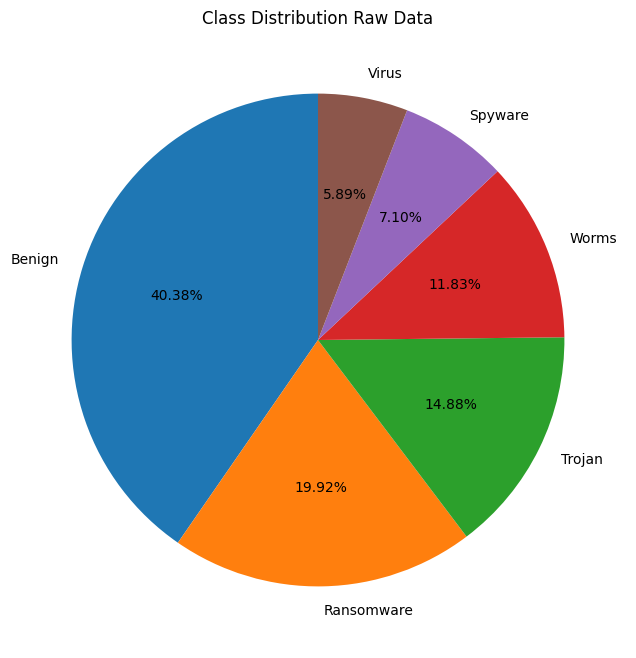

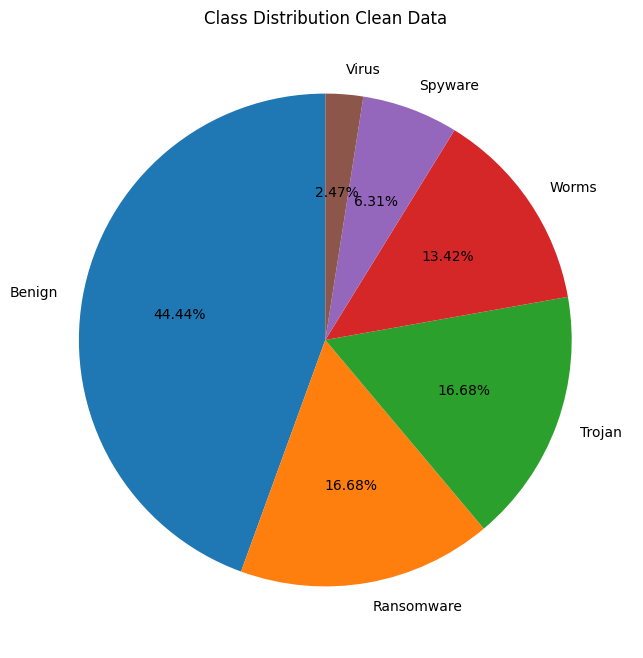

In [4]:

# Drop the 'Name' column
data = data.drop('Name', axis=1)

# Removing duplicate Rows
duplicate_rows = data.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())
data.drop_duplicates(inplace=True)
print("Number of duplicate rows after removal:", data.duplicated().sum())

target = data['Category']
data = data.drop('Category', axis=1)

# Drop columns with standard deviation of 0
data = data.drop(labels=data.loc[:, data.std() == 0].columns, axis=1)

data = pd.concat([data, target], axis=1)
data.to_csv('Cleandata.csv', index=False)

data = pd.read_csv("Cleandata.csv")

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
data['Category'] = label_encoder.fit_transform(data['Category'])

# Store class names for later use
class_names = label_encoder.classes_

# Data visualization
categories = ['Benign', 'Ransomware', 'Trojan', 'Worms', 'Spyware', 'Virus']
Values0 = original_data['Category'].value_counts()
Values1 = data['Category'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(Values0, labels=categories, autopct='%1.2f%%', startangle=90)
plt.title('Class Distribution Raw Data')
plt.savefig(f"Class_Distribution_RAW")

plt.figure(figsize=(8, 8))
plt.pie(Values1, labels=categories, autopct='%1.2f%%', startangle=90)
plt.title('Class Distribution Clean Data')
plt.savefig(f"Class_Distribution_Clean")


In [5]:

# Adjust for dataset 0.5 = 50%   and 1 = 100% 
Adjust = 0.5
data = data.groupby('Category').sample(frac=Adjust, random_state=seed)
print(data.shape)
Pernt = int(Adjust*100)

# Separate features and target
X = data.drop('Category', axis=1)
y = data['Category']

# Define the pipelines
MinMaxScaler_pipeline = Pipeline([
    ("MinMaxScaler", MinMaxScaler()),
    ('tsne', TSNE(n_components=2, learning_rate="auto", init="random", perplexity=100, random_state=seed))
])

Quantile_pipeline = Pipeline([
    ('Quantile', QuantileTransformer(output_distribution='uniform', random_state=seed)),
    ('tsne', TSNE(n_components=2, learning_rate="auto", init="random", perplexity=100, random_state=seed))
])

# Create a dictionary of pipelines
pipelines = {
    'MinMaxScaler': MinMaxScaler_pipeline,
    'Quantile': Quantile_pipeline
}
# Fit and transform the data using the pipelines
dataset_ciselatixat = {}
for name, pipeline in pipelines.items():
    dataset_ciselatixat[name] = pipeline.fit_transform(data.drop('Category', axis=1))


(17329, 76)


In [6]:

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Create directories for saving results
base_output_dir = f'Evaluation_Results_{Pernt}%'
create_directory(base_output_dir)


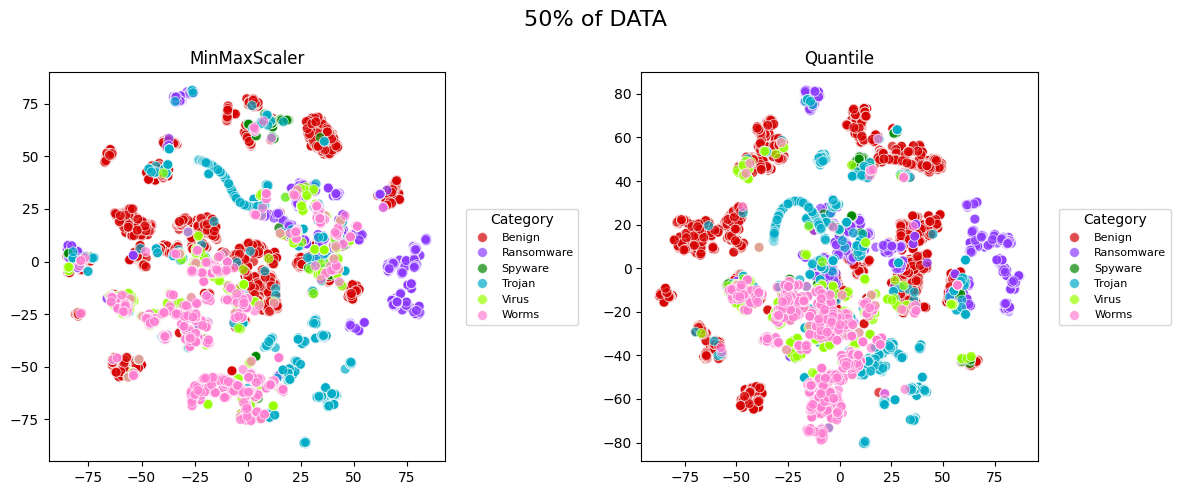

In [7]:

# Visualization
n_categories = len(np.unique(y))
palette = sns.color_palette(cc.glasbey, n_categories)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, X) in enumerate(dataset_ciselatixat.items()):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axs[i], palette=palette, s=50, alpha=0.7, legend='full')
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(handles, class_names, title='Category', loc="center right", bbox_to_anchor=(1.35, 0.5), prop={"size": 8})
    axs[i].set_title(name)

fig.suptitle(f"{Pernt}% of DATA", fontsize=16)
plt.tight_layout()
output_file = os.path.join(base_output_dir, "MinMaxScaler_VS_Quantile.png")
plt.savefig(output_file)

# Save the preprocessed data for later feature selection
X_normal = data.drop('Category', axis=1)

X_MinMaxScaler = pipelines['MinMaxScaler'].named_steps['MinMaxScaler'].fit_transform(X_normal)
X_MinMaxScaler = pd.DataFrame(X_MinMaxScaler, columns=X_normal.columns)

X_Quantile = pipelines['Quantile'].named_steps['Quantile'].fit_transform(X_normal)
X_Quantile = pd.DataFrame(X_Quantile, columns=X_normal.columns)

datasets = {
    'MinMaxScaler': X_MinMaxScaler,
    'Quantile': X_Quantile,}


In [8]:

# Initialize dictionary to hold selected features
selected_features = {method: {} for method in ['Info Gain', 'Permutation Importance', 'Correlation Coefficient']}

# Define feature selection functions
def select_info_gain(X, y, num_features=15):
    info_gain = mutual_info_classif(X, y, random_state=seed)
    indices = np.argsort(info_gain)[-num_features:]
    return X.iloc[:, indices]

def select_permutation_importance(X, y, num_features=15):
    model = RandomForestClassifier(random_state=seed)
    model.fit(X, y)
    perm_importance = permutation_importance(model, X, y, random_state=seed)
    indices = np.argsort(perm_importance.importances_mean)[-num_features:]
    return X.iloc[:, indices]

def select_correlation_coefficient(X, y, num_features=15):
    data_with_target = pd.concat([X, y], axis=1)
    correlation_matrix = data_with_target.corr()
    correlation_with_target = correlation_matrix['Category'].drop('Category')
    indices = np.argsort(correlation_with_target.abs())[-num_features:]
    return X.iloc[:, indices]

# Apply feature selection methods
for dataset_name, X in datasets.items():
    selected_features['Info Gain'][dataset_name] = select_info_gain(X, y)
    selected_features['Permutation Importance'][dataset_name] = select_permutation_importance(X, y)
    selected_features['Correlation Coefficient'][dataset_name] = select_correlation_coefficient(X, y)

# Function to combine features
def combine_features(selected_features, dataset_name):
    info_gain_features = selected_features['Info Gain'][dataset_name]
    perm_import_features = selected_features['Permutation Importance'][dataset_name]
    corr_coeff_features = selected_features['Correlation Coefficient'][dataset_name]
    combined_features = pd.concat([info_gain_features, perm_import_features, corr_coeff_features], axis=1)
    combined_features = combined_features.loc[:, ~combined_features.columns.duplicated()]
    return combined_features

# Combine and deduplicate features for each dataset
final_datasets = {}
for dataset_name in datasets.keys():
    final_datasets[dataset_name] = combine_features(selected_features, dataset_name)

In [ ]:
def compare_and_print_features(datasets):
    feature_sets = {name: set(df.columns) for name, df in datasets.items()}
    common_features = set.intersection(*feature_sets.values())

    for name, features in feature_sets.items():
        print(f"Features in {name} dataset: {len(features)}")
    print(f"Common features: {len(common_features)}")

    print("\nCommon features:")
    print(*sorted(common_features), sep='\n')

    for name, features in feature_sets.items():
        unique = features - common_features
        print(f"\nUnique to {name} dataset ({len(unique)}):")
        print(*sorted(unique), sep='\n')

compare_and_print_features(final_datasets)

In [10]:

# Define hyperparameter grids for each model
param_grids = {
    'KNN': {
        'n_neighbors': range(1, 30, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev'], #, 'minkowski'
        'leaf_size': range(1, 50, 5)
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],# 'poly'],
        'gamma': ['scale'],
        # 'degree': [2]
    },
    'Decision Tree': {
        'max_depth': [2, 3, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_features': ['sqrt', 'log2'],
        'max_depth': range(10, 120, 10),
        'min_samples_split': [2, 6, 10],
        'min_samples_leaf': [1, 3, 4],
        'bootstrap': [True, False]
    },
    'Naive Bayes': {
        'var_smoothing': np.logspace(0, -9, num=100)
    },
    'Ensemble': {
        'voting': ['soft'],
        'weights': [(1, 1, 1, 1, 1), (2, 1, 1, 1, 1), (1, 2, 1, 1, 1), (1, 1, 2, 1, 1), (1, 1, 1, 2, 1), (1, 1, 1, 1, 2)]
    }
}

# Initialize individual models
base_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=seed),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=seed),
    'SVM': SVC(probability=True, random_state=seed)
}

# Initialize models with GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)


In [11]:

# Evaluation method
def evaluate_model(model, X_test, y_test, dataset_name, model_name, ax_roc=None, ax_cm=None):
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    if ax_roc is not None and hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        for i in range(len(np.unique(y_test))):
            fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
        ax_roc.set_xlabel('False Positive Rate')
        ax_roc.set_ylabel('True Positive Rate')
        ax_roc.set_title(f'{model_name} ROC Curve - {dataset_name}')
        ax_roc.legend(loc='lower right')
        overall_roc_auc = roc_auc_score(y_test, y_score, multi_class='ovo')
    else:
        overall_roc_auc = 'N/A'

    if ax_cm is not None:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax_cm, xticks_rotation='vertical', cmap='Blues')
        ax_cm.set_title(f'{model_name} Confusion Matrix - {dataset_name}')

    return recall, precision, f1, accuracy, overall_roc_auc


In [12]:

# Evaluate datasets in parallel
def evaluate_datasets(datasets, base_models, param_grids, cv, output_dir):
    all_results = {}
    best_params = {}

    for dataset_name, X in datasets.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

        for smote_status in ['No SMOTE', 'SMOTE']:
            results = {}

            if smote_status == 'SMOTE':
                smote = SMOTE(random_state=seed)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            else:
                X_train_resampled, y_train_resampled = X_train, y_train

            # Tune and save individual models in parallel
            tuned_models = {}
            def train_model(model_name, model):
                try:
                    grid_search = GridSearchCV(model, param_grids[model_name], cv=cv, scoring='accuracy', error_score='raise', n_jobs=-1)
                    grid_search.fit(X_train_resampled, y_train_resampled)
                    best_model = grid_search.best_estimator_
                   
                    # print(f"{model_name}_{dataset_name}_{smote_status} Best Parameters:\n", grid_search.best_params_)

                    # Save the tuned model
                    model_filename = f"{output_dir}/Saved_models/{model_name}_{dataset_name}_{smote_status}.pkl"
                    joblib.dump(best_model, model_filename)
                    print(f"Model saved to {model_filename}")


                    return model_name, best_model, grid_search.best_params_
                except Exception as e:
                    print(f"Error with model {model_name} on dataset {dataset_name} ({smote_status}): {e}")
                    return model_name, None, None

            # Parallel model tuning using concurrent.futures
            with concurrent.futures.ThreadPoolExecutor() as executor:
                future_to_model = {executor.submit(train_model, model_name, model): model_name for model_name, model in base_models.items()}
                for future in concurrent.futures.as_completed(future_to_model):
                    model_name = future_to_model[future]
                    try:
                        model_name, best_model, best_params_model = future.result()
                        if best_model is not None:
                            tuned_models[model_name] = best_model
                            best_params[f"{model_name}_{dataset_name}_{smote_status}"] = best_params_model
                    except Exception as e:
                        print(f"Error processing model {model_name}: {e}")

            # Create and tune the Ensemble model
            tuned_model_list = [(name, model) for name, model in tuned_models.items()]
            ensemble = VotingClassifier(estimators=tuned_model_list)
            ensemble_cv = GridSearchCV(ensemble, param_grids['Ensemble'], cv=cv, scoring='accuracy', error_score='raise', n_jobs=-1)
            ensemble_cv.fit(X_train_resampled, y_train_resampled)
            best_ensemble = ensemble_cv.best_estimator_

            # print(f"Ensemble_{dataset_name}_{smote_status} Best Parameters:\n", ensemble_cv.best_params_)
            best_params[f"Ensemble_{dataset_name}_{smote_status}"] = ensemble_cv.best_params_
            
             # Save the ensemble model
            ensemble_filename = f"{output_dir}/Saved_models/Ensemble_{dataset_name}_{smote_status}.pkl"
            joblib.dump(best_ensemble, ensemble_filename)
            print(f"Ensemble model saved to {ensemble_filename}")

            # Create separate figures for ROC curves and Confusion Matrices
            fig_roc, axs_roc = plt.subplots(2, 3, figsize=(20, 12))
            fig_cm, axs_cm = plt.subplots(2, 3, figsize=(20, 12))

            # Evaluate all models including the Ensemble
            for i, (model_name, model) in enumerate(list(tuned_models.items()) + [('Ensemble', best_ensemble)]):
                try:
                    ax_roc = axs_roc[i // 3, i % 3]
                    ax_cm = axs_cm[i // 3, i % 3]

                    recall, precision, f1, accuracy, roc_auc = evaluate_model(model, X_test, y_test, f"{dataset_name} ({smote_status})", model_name, ax_roc, ax_cm)
                    results[model_name] = {'Recall': recall, 'Precision': precision, 'F1-Score': f1, 'Accuracy': accuracy, 'ROC AUC': roc_auc}

                except Exception as e:
                    print(f"Error evaluating model {model_name} on dataset {dataset_name} ({smote_status}): {e}")

            # Adjust layout and save figures
            fig_roc.tight_layout()
            fig_roc.savefig(os.path.join(output_dir, f'ROC_Curves_{dataset_name}_{smote_status}.png'))
            plt.close(fig_roc)

            fig_cm.tight_layout()
            fig_cm.savefig(os.path.join(output_dir, f'Confusion_Matrices_{dataset_name}_{smote_status}.png'))
            plt.close(fig_cm)

            all_results[f'{dataset_name} - {smote_status}'] = results

    output_file = os.path.join(base_output_dir, f"best_params_{dataset_name}.csv")
    pd.DataFrame(best_params.items(), columns=['Model', 'Best Parameters']).to_csv(output_file, index=False)

    return all_results


In [ ]:

# Initialize dictionaries to collect results
final_results = {}

# Parallelize evaluation of final datasets
final_output_dir = os.path.join(base_output_dir, 'final_datasets')
create_directory(final_output_dir)

model_dir1 = os.path.join(final_output_dir, 'Saved_models')
create_directory(model_dir1)


with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_dataset = {executor.submit(evaluate_datasets, {dataset_name: dataset}, base_models, param_grids, cv, final_output_dir): dataset_name for dataset_name, dataset in final_datasets.items()}

    for future in concurrent.futures.as_completed(future_to_dataset):
        dataset_name = future_to_dataset[future]
        try:
            result = future.result()
            final_results.update(result)
            print(f"Finished evaluation for dataset: {dataset_name}")
        except Exception as e:
            print(f"Error in dataset {dataset_name}: {e}")

# Display and save results for final datasets
for dataset_key, results in final_results.items():
    print(f"Results for {dataset_key}:")
    results_df = pd.DataFrame(results).T
    # display(results_df)
    output_file = os.path.join(final_output_dir, f'{dataset_key}_results.csv')
    results_df.to_csv(output_file, index=True)

#This take avereage of 580(440) minutes on 50% experiment.

In [14]:
# # Initialize dictionaries to collect results
# feature_selection_results = {}

# # Evaluate feature selection datasets
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     future_to_method = {}
#     for method, datasets_fs in selected_features.items():
#         method_output_dir = os.path.join(base_output_dir, f'feature_selection_{method}')
#         create_directory(method_output_dir)
#         model_dir2 = os.path.join(method_output_dir, 'Saved_models')
#         create_directory(model_dir2)

#         future = executor.submit(evaluate_datasets, datasets_fs, base_models, param_grids, cv, method_output_dir)
#         future_to_method[future] = (method, method_output_dir)

#     for future in concurrent.futures.as_completed(future_to_method):
#         method, method_output_dir = future_to_method[future]
#         try:
#             result = future.result()
#             feature_selection_results[method] = result
#             print(f"Finished evaluation for feature selection method: {method}")

#             # Display and save results for feature selection datasets
#             for dataset_key, dataset_results in result.items():
#                 print(f"\nResults for {dataset_key}:")
#                 results_df = pd.DataFrame(dataset_results).T
#                 # display(results_df)
#                 output_file = os.path.join(method_output_dir, f'{dataset_key}_results.csv')
#                 results_df.to_csv(output_file, index=True)

#         except Exception as e:
#             print(f"Error in feature selection method {method}: {e}")
